## Lab 5: Supervised classification

***ATENTION:*** before running this lab, upgrade geemap, please go to File, New, Terminal, and pass the following command:

**Purpose:**
The purpose of this lab is introduce you to concepts of supervised classification: prediction of nominal or numeric values of a geographic variable from other geographic variables.  You will explore processes of training data collection, classifier selection, classifier training, image classification and accuracy assessment.  At the completion of the lab, you will be able to perform supervised classification in Earth Engine.

**Prerequisites:** Lab 4

### 1. Introduction to classification and regression
For present purposes, define prediction as guessing the value of some geographic variable of interest *g*, using a function *G* that takes as input a pixel vector **p**:

\begin{equation}
G_{T}(p_i) = g_i 
\end{equation}

The *i* in this equation refers to a particular instance from a set of pixels.  Think of *G* as a guessing function and *gi* as the guess for pixel *i*.   The **T** in the subscript of *G* refers to a *training set* (a set of known values for p and the correct g), used to infer the structure of G.  You have to choose a suitable *G* to train with **T**.  When *g* is nominal (e.g. {'water', 'vegetation', 'bare'}), call this setup classification.  When g is numeric, call this setup regression.  This is an incredibly simplistic description of a problem addressed in a broad range of fields including mathematics, statistics, data mining, machine learning, etc.  Interested readers may see [Witten et al. (2011)](http://www.cs.waikato.ac.nz/ml/weka/book.html), [Hastie et al. (2009)](http://statweb.stanford.edu/~tibs/ElemStatLearn/) or [Goodfellow et al (2016)](http://www.deeplearningbook.org/).

### Classification
Classification in Earth Engine has a similar workflow to regression: build the training, train the classifier, classify an image.


In classification, g is nominal.  The first step is to create training data manually.  (Alternatively, upload a shapefile  training data (of points or polygons), for example data collected on the ground with a GPS).  Using Google Earth we can also digitize training polygons.

In [1]:
import ee
ee.Initialize()

import geemap
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Let's import a Landsat 8 image for San Francisco


In [2]:
point = ee.Geometry.Point([-122.4439, 37.7538])
# point = ee.Geometry.Point([-87.7719, 41.8799])

landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(point) \
    .filterDate('2021-01-01', '2021-12-31') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('SR_B[1-7]')

landsat = landsat.multiply(0.0000275).add(-0.2)


vis_params = {
    'min': 0,
    'max': 0.2,
    'bands': ['SR_B5', 'SR_B4', 'SR_B3']
}

In [3]:

# landsat = landsat.updateMask(waterMask)
# print(landsat.getInfo())
Map.centerObject(point, 8)
Map.addLayer(landsat, vis_params, 'Natural color composite')

Map

Map(center=[37.75379999999999, -122.44390000000001], controls=(WidgetControl(options=['position', 'transparent…

Define areas that have unique characteristics: bare soil, water, vegetation

We can use NDVI for help in diferentiating these areas:

In [4]:
# img_name ='ndvi'
# ndvi=landsat.normalizedDifference(['SR_B5', 'SR_B4'])

# vis_params = {
#   'min': -0.2,
#   'max': 1.0,
#   'palette': ['blue','white','brown','yellow', 'lime', 'green','navy']}

# Map.addLayer(ndvi,vis_params,img_name)

# colors = vis_params['palette']
# vmin = vis_params['min']
# vmax = vis_params['max']

# Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name=img_name)

# Map

### Make training dataset

There are several ways you can create a region for generating the training dataset.

- Draw a shape (e.g., rectangle) on the map and the use `region = Map.user_roi`
- Define a geometry, such as `region = ee.Geometry.Rectangle([-122.6003, 37.4831, -121.8036, 37.8288])`
- Create a buffer zone around a point, such as `region = ee.Geometry.Point([-122.4439, 37.7538]).buffer(10000)`
- If you don't define a region, it will use the image footprint by default

In [5]:
# FOR BARE SOIL: \
# how I did this: 
# 1. I zoomed into the Landsat image to a bare soil area
# 2. Click on the polygon icon of the left, and define an area with points, forming a closed polygon
# 3. Run this cell. The last draw polygon is stored in "Map.user_roi"
polygon = Map.user_roi

# Or you can enter defined coordinates as the commented lines below.
# // Create an ee.Geometry.
# polygon = ee.Geometry.Polygon([
#                   [-121.39030016076934, 37.60807367330306],
#                   [-121.37889487541446, 37.61763764877222],
#                   [-121.38989113432118, 37.62488608266359],
#                   [-121.4012069200709, 37.615507786825766]]);

# // Create a Feature from the Geometry.
baresoil = ee.Feature(polygon, {'class': 2, 'name': 'bare soil'});
Map.addLayer(baresoil, {'fill_color':'yellow', 'outline': 1}, name='baresoil')
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

In [6]:
# FOR VEGETATION
# same procedure for water and soil, in this case I looked into a forest area
polygon = Map.user_roi

# // Create an ee.Geometry.
# polygon = ee.Geometry.Polygon([
#                 [-122.24448548567862, 37.21542815360734],
#                 [-122.240411435295, 37.21551898615349],
#                 [-122.23457428064451, 37.21555749104616],
#                 [-122.23385777982398, 37.23144541800057],
#                 [-122.24444605659103, 37.23132764751063]]);

# // Create a Feature from the Geometry.
vegetation = ee.Feature(polygon, {'class': 1, 'name': 'vegetation'});
Map.addLayer(vegetation, {'fill_color':'green', 'outline': 1}, name='vegetation')
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

In [7]:
# FOR WATER
# same procesure as described for soil, in this case, I looked at water areas
# 
polygon = Map.user_roi

# // Create an ee.Geometry.
# polygon = ee.Geometry.Polygon([
#                   [-122.27695595509044, 37.6833127863229],
#                   [-122.26635383955467, 37.683182346233664],
#                   [-122.26478644790062, 37.70212710506073],
#                   [-122.27107078047028, 37.70228065145053],
#                   [-122.27474738958558, 37.701963093009745]]);

# // Create a Feature from the Geometry.
water = ee.Feature(polygon, {'class': 0, 'name': 'water'});
Map.addLayer(water, {'fill_color':'blue', 'outline': 1}, name='water')
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

In [8]:
# FOR WATER again
# same procesure as described for soil, in this case, I looked at water areas
# 
polygon = Map.user_roi

# // Create an ee.Geometry.
# polygon = ee.Geometry.Polygon([
#                   [-122.27695595509044, 37.6833127863229],
#                   [-122.26635383955467, 37.683182346233664],
#                   [-122.26478644790062, 37.70212710506073],
#                   [-122.27107078047028, 37.70228065145053],
#                   [-122.27474738958558, 37.701963093009745]]);

# // Create a Feature from the Geometry.
water1 = ee.Feature(polygon, {'class': 0, 'name': 'water'});
Map.addLayer(water1, {'fill_color':'blue', 'outline': 1}, name='water1')
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

Merge Features into a Feature Collection

In [10]:
trainingFeatures = ee.FeatureCollection([water, vegetation, baresoil, water1])


Specify the bands of the Landsat composite to be used as predictors (i.e. the elements of p):


In [11]:
predictionBands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5' ,'SR_B6','SR_B7']

In the merged FeatureCollection, each Feature should have a property called 'class' where the classes are consecutive integers, one for each class, starting at 0. Verify that this is true.

In [12]:
print(trainingFeatures.first().getInfo())

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-121.524362, 37.973729], [-121.524362, 37.993951], [-121.519397, 37.993951], [-121.519397, 37.973729], [-121.524362, 37.973729]]]}, 'id': '0', 'properties': {'class': 0, 'name': 'water'}}


  Create a training set T for the classifier by sampling the Landsat composite with the merged features:

In [13]:
classifierTraining = landsat.select(predictionBands).sampleRegions(
      collection= trainingFeatures, 
      properties= ['class'], 
      scale= 30
    );

In [14]:
# // Randomly split the data into 60% for training, and 40% for testing
trainingTesting = classifierTraining.randomColumn('random',111009);

training = trainingTesting.filter(ee.Filter.lt('random', 0.6));

testing = trainingTesting.filter(ee.Filter.gte('random', 0.6));

### - Non-linear regression functions

There is a pletora of options for classification in Google Earth Engine. Here is an screenshot of these options:

In [15]:
# ![](https://i.imgur.com/vROsEiq.png)
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/vROsEiq.png")#, width=100, height=100)

- For example, a Classification and Regression Tree (CART, see Brieman et al. 1984) is a machine learning algorithm that can learn non-linear patterns in your data.  Reusing the T table (without the constant term), train a CART as follows:

In [16]:
#hyperparameter to tune
leaf_val=1

cartclassifier = ee.Classifier.smileCart(minLeafPopulation=leaf_val).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    );

- Make predictions over the input imagery (classify in this context is a misnomer):


In [17]:
cartClasifficationImage = landsat.select(predictionBands).classify(cartclassifier);

Map.addLayer(cartClasifficationImage, {'min': 0, 'max': 2,
                                   'palette':['blue', 'green','yellow']},'CART classification');
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

Use a Random Forest classifier

In [18]:
# hyperparameter to tune
trees_val=13
rfClassification = ee.Classifier.smileRandomForest(numberOfTrees=trees_val, seed=111009).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )

In [19]:
# // Perform the RF regression on the landsat image
rfClassificationImage = landsat.select(predictionBands).classify(rfClassification);
    
# // Visualize the RF regression
Map.addLayer(rfClassificationImage,  {'min': 0, 'max': 2,
                                   'palette':['blue','green', 'yellow']}, 'RF classification');

Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

Using Support Vector Machines

In [20]:
# hyperparameter to tune
gamma_val =0.01
# // Create an SVM classifier with custom parameters.
svClassification = ee.Classifier.libsvm(svmType='C_SVC',kernelType='RBF',gamma=gamma_val).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )

In [21]:
# // Perform the RF regression on the landsat image
svClassificationImage = landsat.select(predictionBands).classify(svClassification);
    
# // Visualize the RF regression
Map.addLayer(svClassificationImage,{'min': 0, 'max': 2,
                                   'palette':['blue', 'green','yellow']}, 'SV CLassification');
Map

Map(bottom=405046.0, center=[37.9241594356582, -121.48698806762697], controls=(WidgetControl(options=['positio…

In the classification context, accuracy measurements are often derived from a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

### Accuracy Assessment

Print the confusion matrix and expand the object to inspect the matrix.  The entries represent number of pixels.  Items on the diagonal represent correct classification.  Items off the diagonal are misclassifications, where the class in row i is classified as column j.  It's also possible to get basic descriptive statistics from the confusion matrix.  For example:

### What is a confusion matrix?

A confusion matrix is used here to compare two different data, one the true value and the other the predicted values. We will be using it primarily to compute overall accuracy between the model and the different machine learning results, but confusion matrices also provide explicit information about which  classes were classified incorrectly; not just if pixels were classified incorrectly, but what class they were incorrectly classified as. For an example of how to use and interpret a confusion matrix for LULC remote sensing visit https://www.harrisgeospatial.com/docs/CalculatingConfusionMatrices.html and 
http://gsp.humboldt.edu/olm_2019/courses/GSP_216_Online/lesson6-2/metrics.html

In [26]:
# // Perform the CART classification on the test set

test=testing.classify(cartclassifier)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

In [23]:
import numpy as np
errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[ 911    0    0]
 [   0 1868    0]
 [   0    1  500]]
Overall Accuracy: 0.9996951219512196
Producers Accuracy: [[1], [1], [0.998003992015968]]
Consumers Accuracy: [[1, 0.9994649545211343, 1]]
Kappa: 0.999469829328686


In [24]:
# // Perform the RF classification on the test set

test=testing.classify(rfClassification)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[ 911    0    0]
 [   0 1868    0]
 [   0    1  500]]
Overall Accuracy: 0.9996951219512196
Producers Accuracy: [[1], [1], [0.998003992015968]]
Consumers Accuracy: [[1, 0.9994649545211343, 1]]
Kappa: 0.999469829328686


In [25]:
# // Perform the SVR classification on the test set

test=testing.classify(svClassification)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[ 911    0    0]
 [   0 1868    0]
 [ 137  135  229]]
Overall Accuracy: 0.9170731707317074
Producers Accuracy: [[1], [1], [0.45708582834331335]]
Consumers Accuracy: [[0.8692748091603053, 0.9326010983524713, 1]]
Kappa: 0.8499900543755788


### BONUS: Hyperparameters tuning

A random forest is a collection of random trees the predictions of which are used to compute an average (regression) or vote on a label (classification).  Note that the only parameter to the classifier is the number of trees.  How many trees should you use?  Making that choice is best done by hyperparameter tuning.  For example, 


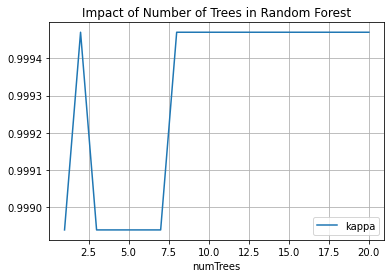

In [27]:
numTrees = ee.List.sequence(1, 20, 1)


def trees(t):
    rfclass = ee.Classifier.smileRandomForest(numberOfTrees=t, seed=111009).train(
    features= training, 
    classProperty= 'class', 
    inputProperties= predictionBands)
    
    rfTesting = testing.classify(rfclass)
    testAccuracy = rfTesting.errorMatrix('class', 'classification');
    kappa= testAccuracy.kappa();       
    return kappa


kappa_trees=numTrees.map(trees)
value_info = kappa_trees.getInfo()

# print(rmse_trees.getInfo())

import pandas as pd
df =pd.DataFrame(value_info,columns=['kappa'])
df['numTrees'] = numTrees.getInfo() 

ax =df.plot.line(x='numTrees', 
             y='kappa',
             title= 'Impact of Number of Trees in Random Forest'
             )
ax.grid()

same for svc

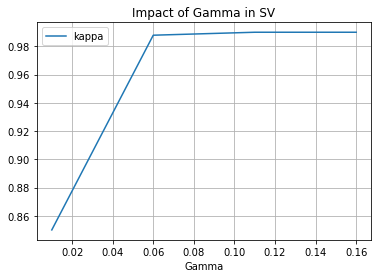

In [28]:
gamma_vals = ee.List.sequence(0.01, 0.2, 0.05)


def gammas(t):
    svclass = ee.Classifier.libsvm(svmType='C_SVC',kernelType='RBF',gamma=t).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )
    
    svTesting = testing.classify(svclass)
    testAccuracy = svTesting.errorMatrix('class', 'classification');
    kappa= testAccuracy.kappa();       
    return kappa


kappa_gama=gamma_vals.map(gammas)
value_info = kappa_gama.getInfo()

# print(rmse_gama.getInfo())

import pandas as pd
df =pd.DataFrame(value_info,columns=['kappa'])
df['Gamma'] = gamma_vals.getInfo() 

ax =df.plot.line(x='Gamma', 
             y='kappa',
             title= 'Impact of Gamma in SV'
             )
ax.grid()

now for Cart

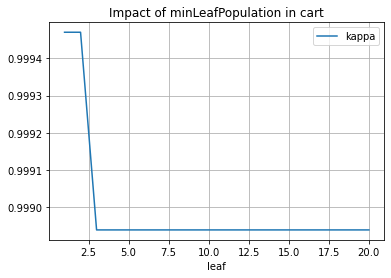

In [29]:
leaf_vals = ee.List.sequence(1, 20, 1)


def leaves(t):
    cartclass= ee.Classifier.smileCart(minLeafPopulation=t).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )
    
    cartTesting = testing.classify(cartclass)
    testAccuracy = cartTesting.errorMatrix('class', 'classification');
    kappa= testAccuracy.kappa();       
    return kappa


kappa_leaf=leaf_vals.map(leaves)
value_info = kappa_leaf.getInfo()

# print(rmse_gama.getInfo())

import pandas as pd
df =pd.DataFrame(value_info,columns=['kappa'])
df['leaf'] = leaf_vals.getInfo() 

ax =df.plot.line(x='leaf', 
             y='kappa',
             title= 'Impact of minLeafPopulation in cart'
             )
ax.grid()

### Assignment

Recreate this notebook for Logan UT, and add 3 more polygons that describe soil, vegetation and water (there must be 3 polygons per class). Make sure your CART, SVC and Random Forest uses the tuned hyperparameters when discussing your accuracy found. Are the models behaving similarly? Do they statistically perform different than this example? Discuss it.

Note: if after a while the code does not run, or shows an error, reduce the size of the polygons. 